### 1. Scraping Subreddits with PRAW

In [ ]:
# Imports

import pandas as pd
import seaborn as sns
import requests, json, time, datetime
import praw

from bs4 import BeautifulSoup
import regex as re

from nltk.tokenize import RegexpTokenizer
import nltk as nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

In [2]:
# Dictionary to store Reddit crendentials
cred_dict = {
    
    'id': 'N/A',
    'secret': 'N/A',
    'user': 'N/A',
    'pass': 'N/A'
}

In [ ]:
# Serialize the credential dictionary to a dictionary of json formatted strings
#cred_json = json.dumps(cred_dict)

In [ ]:
# Write credentials to file as json
#with open('red_creds.json', 'w+') as file:
    #file.write(cred_json)

In [3]:
# Read the credentials back in from the file
cred_file = open('red_creds.json', 'r')

In [5]:
# Deserialize json to a Python object
access_creds = json.loads(cred_file.read())

In [8]:
# Instantiate Reddit class via credentials
reddit = praw.Reddit(
    
    client_id = access_creds['id'],
    client_secret = access_creds['secret'],
    username = access_creds['user'],
    password = access_creds['pass'],
    user_agent = 'DSI'
    
)

In [9]:
# Define a function to calculate the age of a post
def age(post_time):
    return (time.time() - post_time) / 60

In [10]:
# Define a function that will retrieve a batch of Reddit posts
def get_batch(name):
    
    # Returns a subreddit object for the corresponding input subreddit name
    data = reddit.subreddit(name)
    
    # Construct a list to hold the first 1000 posts
    roof = [i for i in data.hot(limit=1000)]
    
    # Create list to hold reddit post titles
    titles = [beam.title for beam in roof] 
    
    # Create list to hold the number of comments left on each post
    activity = [beam.num_comments for beam in roof] 
    
    # Create list to hold the calculated age of each post
    ages = [age(beam.created_utc) for beam in roof]
    
    # Create a list to hold each posts corresponding subreddit name
    sub_name = [name for beam in roof]
    
    # Construct a dictionary to hold the information above
    thread_dict = {
        
        'title': titles,
        'comments': activity,
        'age': ages,
        'thread': sub_name
    }
    
    # Convert to Pandas DataFrame and return
    return pd.DataFrame(thread_dict)

In [11]:
# Create a DataFrame for each of the two genres
rock = get_batch('rock')
rap = get_batch('rap')

### 2. EDA and Data Cleaning

In [12]:
rock.head(10) # Show the first 10 rows of rock data

,title,comments,age,thread
0,AC/DC - Realize (Official Audio),4,357.322690,rock
1,AC/DC Releases New Single ‘Realize’ From ‘Powe...,0,192.622690,rock
2,After teasing us for years with #tpr4 The Pret...,0,252.506023,rock
3,GEEZER BUTLER Rules Out More BLACK SABBATH Sho...,2,799.522690,rock
4,Black Sabbath - War Pigs (1974 California Jam),5,1207.289356,rock
5,Lunatic Band - Breathe (Official Music Video),0,146.706023,rock
6,Name your Top 5 Rock Bands and why,4,284.406023,rock
7,KISS’s PAUL STANLEY Writes A Touching Message ...,0,215.306023,rock
8,Do you know these spanish guys?,0,221.706023,rock
9,"Patty Smyth Talks Comeback, Unsupervised Freed...",0,16.872690,rock


In [13]:
rap.head(10) # Show the first 10 rows of rap data

,title,comments,age,thread
0,Travis tweaking,3,852.454124,rap
1,My painting of Tupac...original has already so...,12,1432.787457,rap
2,Fbz,0,40.437457,rap
3,MO3 Officially Confirmed Passed (Boosie Artist),0,45.304124,rap
4,"I'm new to rapping, where can I get some feedb...",10,212.037457,rap
5,Moe 3 dead (close friend confirms) rip moe 3,1,105.087457,rap
6,this is a comment i found underneath a mac mil...,2,534.620791,rap
7,Rapper Moe3 Shot On Freeway In Dallas,0,119.204124,rap
8,"[free] travis scott rodeo type beat ~ ""divided""",0,7.254124,rap
9,Rapper MO3 Reported Shot,4,143.370791,rap


In [14]:
# Display DataFrame shapes
print('Rock Shape: ' + str(rock.shape))
print('Shape Shape: ' + str(rap.shape))

Rock Shape: (999, 4)
Shape Shape: (997, 4)


In [18]:
# Display DataFrame column data types
print('Rock Subreddit Data Types\n\n' + str(rock.dtypes))
print()
print('Rap Subreddit Data Types\n\n' + str(rap.dtypes))

Rock Subreddit Data Types

title        object
comments      int64
age         float64
thread       object
dtype: object

Rap Subreddit Data Types

title        object
comments      int64
age         float64
thread       object
dtype: object


In [19]:
# Display value counts for each of the data types
print('Rock Data Type Counts: \n\n' + str(rock.dtypes.value_counts()))
print()
print('Rap Data Type Counts: \n\n' + str(rap.dtypes.value_counts()))

Rock Data Type Counts: 

object     2
float64    1
int64      1
dtype: int64

Rap Data Type Counts: 

object     2
float64    1
int64      1
dtype: int64


In [20]:
# Get null value counts
print('Rock Null Counts: \n\n' + str(rock.isnull().sum().value_counts()))
print()
print('Rap Null Counts: \n\n' + str(rap.isnull().sum().value_counts()))

Rock Null Counts: 

0    4
dtype: int64

Rap Null Counts: 

0    4
dtype: int64


In [21]:
# Download NLTK stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Antho\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
# Define a custom function that will clean a DataFrame column
def clean_text_column(column):
    
    # Define a list that will contain words in a column of subreddit titles
    words_list = [] 
    
    # Clean out punctuation and lowercase letters
    cleaned_column = [re.sub("[^a-zA-Z]", " ", BeautifulSoup(text).get_text().lower()) for text in column]
    
    # Convert to Pandas series
    column = pd.Series(cleaned_column)
    
    # Instantiate tokenizer
    tokenizer = RegexpTokenizer('\s+', gaps=True)
    
    # For each line of text in the column
    for line in column:
        
        # Tokenize the line
        test = tokenizer.tokenize(line)
        
        # Append all words not belonging to the group of English stopwords
        words_list.append(' '.join([word for word in test if word not in stopwords.words('english')]))
    
    # Return the cleaned column as a Pandas series
    return pd.Series(words_list)

In [42]:
# Clean the two columns in question
rock_unique = clean_text_column(rock['title'])
rap_unique = clean_text_column(rap['title'])

C:\Users\Antho\Anaconda3\lib\site-packages\bs4\__init__.py:357: UserWarning: "https://music.youtube.com/watch?v=dRuRKirloQ8&feature=share" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\Antho\Anaconda3\lib\site-packages\bs4\__init__.py:357: UserWarning: "https://youtu.be/95dDXq9OV90" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
C:\Users\Antho\Anaconda3\lib\site-packages\bs4\__init__.py:357: UserWarning: "https://open.spotify.com/track/60GHfoC62OUZRnNuyeBgcP?si=d1-_lHDPSR2-t762afrnRg" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests t

In [43]:
rock_unique.head(10) # Show the first 10 cleaned rows of rock data

0                         ac dc realize official audio
1              ac dc releases new single realize power
2    teasing us years tpr pretty reckless announced...
3    geezer butler rules black sabbath shows says b...
4                black sabbath war pigs california jam
5            lunatic band breathe official music video
6                                  name top rock bands
7    kiss paul stanley writes touching message make...
8                                    know spanish guys
9    patty smyth talks comeback unsupervised freedo...
dtype: object

In [44]:
rap_unique.head(10) # Show the first 10 cleaned rows of rap data

0                                      travis tweaking
1    painting tupac original already sold still art...
2                                                  fbz
3         mo officially confirmed passed boosie artist
4                             new rapping get feedback
5               moe dead close friend confirms rip moe
6            comment found underneath mac miller video
7                       rapper moe shot freeway dallas
8            free travis scott rodeo type beat divided
9                              rapper mo reported shot
dtype: object

In [45]:
# Get null value counts after cleaning
print('Rock Null Counts: \n\n' + str(rock_unique.isnull().sum()))
print()
print('Rap Null Counts: \n\n' + str(rap_unique.isnull().sum()))

Rock Null Counts: 

0

Rap Null Counts: 

0


In [53]:
# Replace original titles with cleaned titles
rock['title'] = rock_unique
rap['title'] = rap_unique

In [57]:
rock.head(10) # Display the first 10 rows

,title,comments,age,thread
0,ac dc realize official audio,4,357.322690,rock
1,ac dc releases new single realize power,0,192.622690,rock
2,teasing us years tpr pretty reckless announced...,0,252.506023,rock
3,geezer butler rules black sabbath shows says b...,2,799.522690,rock
4,black sabbath war pigs california jam,5,1207.289356,rock
5,lunatic band breathe official music video,0,146.706023,rock
6,name top rock bands,4,284.406023,rock
7,kiss paul stanley writes touching message make...,0,215.306023,rock
8,know spanish guys,0,221.706023,rock
9,patty smyth talks comeback unsupervised freedo...,0,16.872690,rock


In [58]:
rap.head(10) # Display the first 10 rows

,title,comments,age,thread
0,travis tweaking,3,852.454124,rap
1,painting tupac original already sold still art...,12,1432.787457,rap
2,fbz,0,40.437457,rap
3,mo officially confirmed passed boosie artist,0,45.304124,rap
4,new rapping get feedback,10,212.037457,rap
5,moe dead close friend confirms rip moe,1,105.087457,rap
6,comment found underneath mac miller video,2,534.620791,rap
7,rapper moe shot freeway dallas,0,119.204124,rap
8,free travis scott rodeo type beat divided,0,7.254124,rap
9,rapper mo reported shot,4,143.370791,rap


In [60]:
rock.describe() # Get summary statistics for rock

,comments,age
count,999.000000,999.000000
mean,1.637638,23169.372973
std,5.721914,14460.388317
min,0.000000,16.872690
25%,0.000000,10667.381023
50%,0.000000,21572.406023
75%,1.000000,36060.964356
max,93.000000,49294.122690


In [62]:
rap.describe() # Get summary statistics for rap

,comments,age
count,997.000000,997.000000
mean,1.793380,6853.201288
std,7.731659,4168.039691
min,0.000000,7.254124
25%,0.000000,3071.437457
50%,0.000000,6914.154124
75%,1.000000,10212.637474
max,101.000000,16007.720807


### 3. Preprocessing & Visualizations

In [63]:
# Define a function to find and visualize the most common words within thread titles
def plot_common_words(column):
    
    # Instantiate CountVectorizer to Convert a collection of text documents to a matrix of token counts
    cv = CountVectorizer(stop_words='english')
    
    # Call fit_transform to learn the vocabulary dictionary and return document-term matrix
    words = cv.fit_transform(column)
    
    # Convert the words to a DataFrame representation with their corresponding feature names
    df_words = pd.DataFrame(words.toarray(), columns=cv.get_feature_names())
    
    # Take the top 10 most common words
    df_common = pd.DataFrame(df_words.sum().sort_values(ascending=False).head(10))
    
    # Relabel a column
    df_common.rename(columns={0: 'Count'}, inplace=True)
    
    # Define a barplot to display the most common words
    ax = sns.barplot(df_common.index, df_common['Count']);
    
    # Set the x and y-labels
    ax.set(xlabel='Word', ylabel='Word Count')

C:\Users\Antho\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


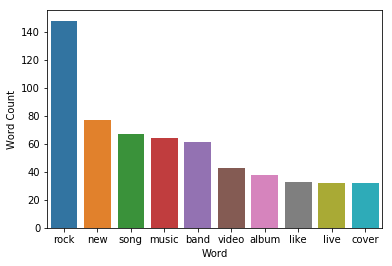

In [65]:
# Visualize the most common terms in the rock subreddit
plot_common_words(rock['title'])

C:\Users\Antho\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


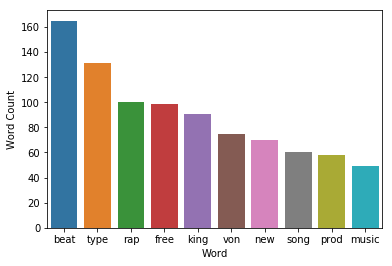

In [66]:
# Visualize the most common terms in the rap subreddit
plot_common_words(rap['title'])

In [67]:
# Concatenate the two dataframes prior to model development
df = pd.concat([rock, rap], axis=0)

In [69]:
# Reassign rock to 1 and rap to 0 prior to binary classification
df['thread'] = df['thread'].map(lambda x: 1 if x == 'rock' else 0)

The data contained in the DataFrame below is going to be used to train a model in order to classify subreddit posts by name. This is a binary classification problem so I used 1 to represent rock and 0 to represent rap.

In [73]:
df.rename(columns={'thread': 'label'}, inplace=True) # Rename thread column

In [75]:
df.head() # Double check the label change

,title,comments,age,label
0,ac dc realize official audio,4,357.322690,1
1,ac dc releases new single realize power,0,192.622690,1
2,teasing us years tpr pretty reckless announced...,0,252.506023,1
3,geezer butler rules black sabbath shows says b...,2,799.522690,1
4,black sabbath war pigs california jam,5,1207.289356,1


### 4. Modeling

In [79]:
df['label'].value_counts() # Double check mapping function output

1    999
0    997
Name: label, dtype: int64

In [82]:
print('Training Data Shape: ' + str(df.shape)) # Find the shape of the new combined text DataFrame

Training Data Shape: (1996, 4)


In [83]:
df.isnull().sum() # Double check null counts

title       0
comments    0
age         0
label       0
dtype: int64

In [84]:
# Assign model training variables
X = df['title']
y = df['label']

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y) # Split the data into training and testing sets

In [98]:
# Validate the stratify parameter
print('Original Label Proportions: \n\n' + str(df['label'].value_counts(normalize=True)))
print()
print('Testing Label Proportions: \n\n' + str(y_test.value_counts(normalize=True)))

Original Label Proportions: 

1    0.500501
0    0.499499
Name: label, dtype: float64

Testing Label Proportions: 

1    0.501002
0    0.498998
Name: label, dtype: float64


The original label proportions appear to approximately match the testing label proportions, validating the use of the stratify parameter when performing the train/test split.

In [ ]:
# Define a custom function to remove a given list of words from a dataframe column.
def remove_given_words(column, given_words):
    
    cv = CountVectorizer(stop_words=given_words)
    words = cv.fit_transform(column)
    df_words = pd.DataFrame(words.toarray(), columns=cv.get_feature_names())
    print(df_words.sum())
    return df_words

In [ ]:
# Consider gridsearching over logistic regression parameters
lr = LogisticRegression()
lr.get_params()

In [ ]:
# Establish a pipeline to contain transformers and a final estimator
pipe = Pipeline([
    
    ('cvec', CountVectorizer()), # Converts a collection of text into a matrix of token counts
    ('lr', LogisticRegression()) # For predicting binary class labels
    #('lr', LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5))
    
])

# The elasticnet is a regularized expression method that linearly combines the L1 and L2 Lasso and Ridge methods.
# The saga solver supports the elasticnet regularizaion penalty
# l1_ratio sets the proportion of L1 and L2 regularization. Setting it to 0.5 applies equal amounts of L1 and L2 regularization.

# Set the pipeline parameters that I want gridsearch to vary
pipe_params = {
    
    'cvec__max_features': [100, 500, 1000], # Consider the first 100, 500 and 1000 words
    'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)], # Consider 1, 2 and 3 grams
    'cvec__stop_words': [None, 'english'] # Build the model with no stopwords and with English stopwords
    #'lr__C': [1, 1e3, 1e6, 1e9] # Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.
    
}

# Instantiate GridSearchCV, fit the model and find the best set of parameters
gs = GridSearchCV(pipe, param_grid=pipe_params, cv=5)
gs.fit(X_train, y_train)
gs_model = gs.best_estimator_

# Display relevant model scores
print(f'CVEC/LR Best Accuracy Score: {round(gs.best_score_, 3)}')
print(f'CVEC/LR Training Score: {round(gs_model.score(X_train, y_train), 3)}')
print(f'CVEC/LR Testing Score: {round(gs_model.score(X_test, y_test), 3)}')
print(f'Score Drop: {round(round(gs_model.score(X_train, y_train), 3) - round(gs_model.score(X_test, y_test), 3), 3)}')

Varying the amount and types of regularization in the model had very little effect on the scores. My original model was chosen as the best because of its simplicity and manageable amount of overfitting.

In [ ]:
# Establish a pipeline to contain transformers and a final estimator
pipe2 = Pipeline([
    
    ('tfidf', TfidfVectorizer()), # TFIDF is a statistical measure of the importance of a specific word to a corpus
    ('lr', LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5)) # For predicting binary class labels
    
])

# The elasticnet is a regularized expression method that linearly combines the L1 and L2 Lasso and Ridge methods.
# The saga solver supports the elasticnet regularizaion penalty
# l1_ratio sets the proportion of L1 and L2 regularization. Setting it to 0.5 applies equal amounts of L1 and L2 regularization.

# Set the pipeline parameters that I want gridsearch to vary
pipe_params2 = {
    
    'tfidf__max_features': [100, 500, 1000], # Consider the first 100, 500 and 1000 words
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)], # Consider 1, 2 and 3 grams
    'tfidf__stop_words': [None, 'english'], # Build the model with no stopwords and with English stopwords
    'lr__C': [1, 1e3, 1e6, 1e9] # Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.
}

# Instantiate GridSearchCV, fit the model and find the best set of parameters
gs2 = GridSearchCV(pipe2, param_grid=pipe_params2, cv=5)
gs2.fit(X_train, y_train)
gs_model2 = gs2.best_estimator_

# Display relevant model scores
print(f'TFIDF/LR Best Accuracy Score: {round(gs2.best_score_, 3)}')
print(f'TFIDF/LR Training Score: {round(gs_model2.score(X_train, y_train), 3)}')
print(f'TFIDF/LR Testing Score: {round(gs_model2.score(X_test, y_test), 3)}')
print(f'Score Drop: {round(round(gs_model2.score(X_train, y_train), 3) - round(gs_model2.score(X_test, y_test), 3), 3)}')

Varying the amount and types of regularization in the model had a negative effect on the scores but led to a drastic decrease in overfitting. The new model varying the amount of elasticnet regularization was chosen as best.

In [ ]:
# Consider gridsearching over BernoulliNB parameters
nb = BernoulliNB()
nb.get_params()

In [ ]:
# Establish a pipeline to contain transformers and a final estimator
pipe4 = Pipeline([
    
    ('cvec', CountVectorizer()), # Converts a collection of text into a matrix of token counts
    ('nb', BernoulliNB()) # Bernoulli Naive Bayes is used to predict a binary outcome
    
])

# Set the pipeline parameters that I want gridsearch to vary
pipe_params4 = {
    
    'cvec__max_features': [100, 500, 1000], # Consider the first 100, 500 and 1000 words
    'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)], # Consider 1, 2 and 3 grams
    'cvec__stop_words': [None, 'english'] # Build the model with no stopwords and with English stopwords
}

# Instantiate GridSearchCV, fit the model and find the best set of parameters
gs4 = GridSearchCV(pipe4, param_grid=pipe_params4, cv=5)
gs4.fit(X_train, y_train)
gs_model4 = gs4.best_estimator_

# Display relevant model scores
print(f'CVEC/BNB Best Accuracy Score: {round(gs4.best_score_, 3)}')
print(f'CVEC/BNB Training Score: {round(gs_model4.score(X_train, y_train), 3)}')
print(f'CVEC/BNB Testing Score {round(gs_model4.score(X_test, y_test), 3)}')
print(f'Score Drop: {round(round(gs_model4.score(X_train, y_train), 3) - round(gs_model4.score(X_test, y_test), 3), 3)}')

In [ ]:
# Establish a pipeline to contain transformers and a final estimator
pipe5 = Pipeline([
    
    ('tfidf', TfidfVectorizer()), # TFIDF is a statistical measure of the importance of a specific word to a corpus
    ('nb', BernoulliNB()) # Bernoulli Naive Bayes is used to predict a binary outcome
    
])

# Set the pipeline parameters that I want gridsearch to vary
pipe_params5 = {
    
    'tfidf__max_features': [100, 500, 1000], # Consider the first 100, 500 and 1000 words
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)], # Consider 1, 2 and 3 grams
    'tfidf__stop_words': [None, 'english'] # Build the model with no stopwords and with English stopwords
}

# Instantiate GridSearchCV, fit the model and find the best set of parameters
gs5 = GridSearchCV(pipe5, param_grid=pipe_params5, cv=5)
gs5.fit(X_train, y_train)
gs_model5 = gs5.best_estimator_

# Display relevant model scores
print(f'TFIDF/BNB Best Accuracy Score: {round(gs5.best_score_, 3)}')
print(f'TFIDF/BNB Training Score: {round(gs_model5.score(X_train, y_train), 3)}')
print(f'TFIDF/BNB Testing Score {round(gs_model5.score(X_test, y_test), 3)}')
print(f'Score Drop: {round(round(gs_model5.score(X_train, y_train), 3) - round(gs_model5.score(X_test, y_test), 3), 3)}')

The data under consideration for this project are in text form, so some form of text vectorization must occur before instantiating any sort of model. I chose to implement pipelines vectorizing the text data first using CountVectorizer and second using TfidfVectorizer. This is a binary classification problem so the first two pipelines used a Logistic Regression (LR) model and functioned as a baseline. Added benefits of using LR include interpretability, accuracy and ease of implementation. The Naive Bayes classifier was then implemented and compared to the results of LR. 

For more information regarding model selection, see README.md. 